Extracting EDF parameters from C:\Users\Ana-Sophia Redstone\OneDrive\Documents\GitHub\Neurociencias-2026-1\S03_datasets\cap-sleep-database-1.0.0\ins6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24729599  =      0.000 ... 48299.998 secs...


C:\Users\Ana-Sophia Redstone\AppData\Local\Temp\ipykernel_20668\1454026230.py:15: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
C:\Users\Ana-Sophia Redstone\AppData\Local\Temp\ipykernel_20668\1454026230.py:15: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Canales detectados: ['ROC-LOC', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'C4-A1', 'EMG1-EMG2', 'ECG1-ECG2', 'DX1-DX2', 'SX1-SX2', 'SAO2', 'HR', 'PLETH', 'STAT']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3381 samples (6.604 s)



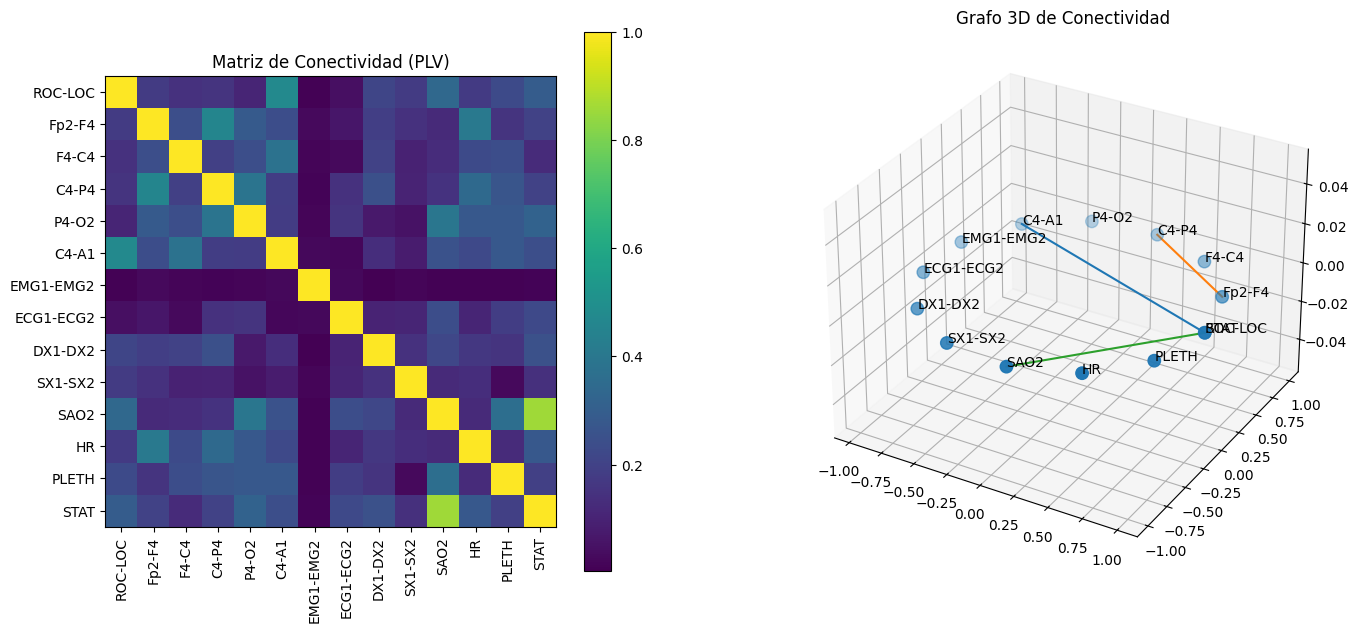

In [8]:
# CAP SLEEP DATA BASE - patrón ciclico de actividad del sueño , es un ánalisis de varios trastornos del sueño por medio de EEG y otras medidas pero en este caso solo utilizaré EEG.
# Proyecto final : Ana-Sophia Redstone Mereles 

# Importar las librerías a utilizar 

import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, coherence

# Definir la ruta de los archivos edf 

edf_path = r"C:\Users\Ana-Sophia Redstone\OneDrive\Documents\GitHub\Neurociencias-2026-1\S03_datasets\cap-sleep-database-1.0.0\ins6.edf"

raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.pick_types(eeg=True)  # dejamos solo EEG

print("Canales detectados:", raw.info["ch_names"])

# Filtrado de señal 

raw.filter(0.5, 40)
data = raw.get_data()
sfreq = raw.info["sfreq"]
n_channels = data.shape[0]

# Análisis por medio de una ventana de 10 segunditos

t_ini = 10
t_fin = 20
s_ini = int(t_ini * sfreq)
s_fin = int(t_fin * sfreq)

segment = data[:, s_ini:s_fin]

# MATRIZ 1 : Correlación de Pearson 

pearson_mat = np.corrcoef(segment)

# MATRIZ 2 : Coherencia Espectral  

coh_mat = np.zeros((n_channels, n_channels))

for i in range(n_channels):
    for j in range(n_channels):
        f, coh = coherence(segment[i], segment[j], fs=sfreq)
        coh_mat[i, j] = np.mean(coh)  # promedio de la coherencia

# MATRIZ 3 : Fase PLV (phase locking value) 

analytic = hilbert(segment)
phase = np.angle(analytic)

plv_mat = np.zeros((n_channels, n_channels))

for i in range(n_channels):
    for j in range(n_channels):
        phase_diff = phase[i] - phase[j]
        plv = np.abs(np.mean(np.exp(1j * phase_diff)))
        plv_mat[i, j] = plv

# MATRIZ SELECCIONADA : PLV 

matrix = plv_mat  

labels = raw.info["ch_names"]

# PLOT: Heatmap + Grafo 3D (juntos)

fig = plt.figure(figsize=(16, 7))

# HEATMAP ( mapita de calor)

ax1 = fig.add_subplot(1, 2, 1)
im = ax1.imshow(matrix, cmap="viridis")
ax1.set_title("Matriz de Conectividad (PLV)")
ax1.set_xticks(range(n_channels))
ax1.set_yticks(range(n_channels))
ax1.set_xticklabels(labels, rotation=90)
ax1.set_yticklabels(labels)
plt.colorbar(im, ax=ax1)

# Grafo 3D 

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.set_title("Grafo 3D de Conectividad")

# Coordenadas para un solo Grafo (artificiales) 

theta = np.linspace(0, 2*np.pi, n_channels)
x = np.cos(theta)
y = np.sin(theta)
z = np.zeros(n_channels)

# Graficar Nodos 

ax2.scatter(x, y, z, s=80)

# Graficar Conexiones Fuertes 

threshold = np.percentile(matrix, 90)  # top 10%
for i in range(n_channels):
    for j in range(i+1, n_channels):
        if matrix[i, j] > threshold:
            ax2.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]])

for i in range(n_channels):
    ax2.text(x[i], y[i], z[i], labels[i])

plt.show()
